# Imports

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt

from nltk.translate.bleu_score import corpus_bleu

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
# to pad text sequences to make all of them the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
DATASET_DIR = 'drive/MyDrive/Colab Data/Datasets/flickr8.zip'
MODEL_DIR = 'drive/MyDrive/Colab Data/Models/VGG16_LSTM_flickr8k'
FEATURES_DIR = 'drive/MyDrive/Colab Data/Pretrained Features/VGG16'

# Extract Image Features

In [3]:
# Load VGG16 model
model = VGG16()
# remove last layer of model because we only need the previous layers that extract image features
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# extract features from image
with ZipFile(DATASET_DIR, 'r') as zip:
  images_names = list(filter(lambda x: x.endswith('.jpg'), zip.namelist()))

  features = {}
  for img_name in tqdm(images_names):
      data = zip.open(img_name)
      img = Image.open(data)
      img = img.resize((224,224))
      # convert image pixels to numpy array
      img = img_to_array(img)
      # reshape data for model
      img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
      # preprocess image for vgg
      img = preprocess_input(img)
      # extract features
      feature = model.predict(img, verbose=0)
      # get image ID
      img_id = img_name.split('.')[0]
      # store feature
      features[img_id.split('/')[1]] = feature

In [ ]:
# # store features in pickle
# pickle.dump(features, open(os.path.join(FEATURES_DIR, 'features.pkl'), 'wb'))

In [4]:
# load features from pickle
with open(os.path.join(FEATURES_DIR, 'features.pkl'), 'rb') as f:
  features = pickle.load(f)

# Load Captions Data

In [5]:
with ZipFile(DATASET_DIR, 'r') as zip:
  captions_doc = zip.read('captions.txt').decode()

In [6]:
# create mapping of image to captions
mapping = {}

# process lines
for line in tqdm(captions_doc.split('\n')[1:]):
  # split the line by comma(,)
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  image_id = image_id.split('.')[0]
  caption = " ".join(caption)

  # create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  # store the caption corresponding to image id
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

# Preprocess Text Data

In [7]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # convert to lowercase
      caption = caption.lower()
      # delete digits, special chars, ...
      caption = caption.replace(r'[^A-Za-z]', '')
      # delete additional spaces
      caption = caption.replace(r'\s+', ' ')
      # add start and end tags to the caption
      caption = " ".join([word for word in caption.split() if len(word)>1])
      caption = 'startseq ' + caption + ' endseq'
      captions[i] = caption

In [8]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
# preprocess the text
clean(mapping)

In [10]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Tokenize the Text

In [11]:
# get all captions
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [12]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [13]:
# get maximum length of the caption (for padding the smaller length captions)
max_length = max(len(caption.split()) for caption in all_captions)

# Train Test Split

In [14]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# Get and Preprocess Batches Input and Output Data

In [15]:
# '<start> girl going into wooden building <end>'

# X                                                  y
# <start>                                           girl
# <start> girl                                      going
# <start> girl going                                into
# ..........................................................
# <start> girl going into wooden building           <end>

In [16]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loop over images
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split the sequence into X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pairs
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence (one-hot encoding)
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        # give the batch inputs and outputs to the model
        yield [X1, X2], y
        # reinitialize the batch inputs for the next batch
        X1, X2, y = list(), list(), list()
        n = 0


# Model Creation

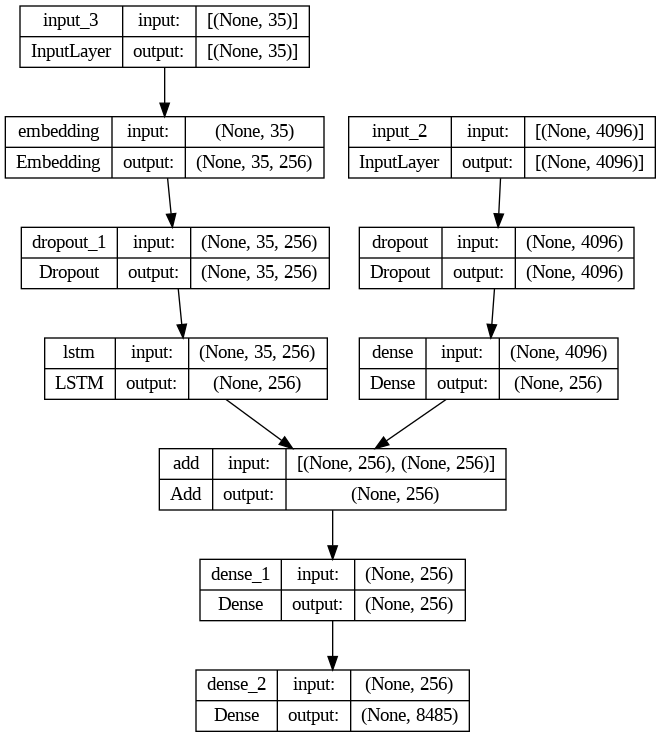

In [17]:
# ENCODER MODEL
# Image feature layers
inputs1 = Input(shape=(4096,)) # vgg output is 4069 features
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# DECODER MODEL
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# WHOLE MODEL
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# plot the model
plot_model(model, show_shapes=True)

# Model Training

In [ ]:
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
  # create data generator
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for one epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
# model.save(os.path.join(MODEL_DIR, 'model.h5'))

In [18]:
model = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'model.h5'))

# Generate Captions for Image

In [19]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [20]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
  # add start tag for generation process
  in_text = 'startseq'
  # iterate over the max length of sequence
  for i in range(max_length):
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    yhat = model.predict([image, sequence], verbose=0)
    # get index with highest probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word(yhat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    in_text += ' ' + word
    # stop if we reach end tag
    if word == 'endseq':
      break
  return in_text

In [21]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)

  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()

  # append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# calculate BLEU score (n-gram)
print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')
print(f'BLEU-3: {corpus_bleu(actual, predicted, weights=(0.334, 0.333, 0.333, 0))}')
print(f'BLEU-4: {corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))}')

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.5132631578947369
BLEU-2: 0.3002184818059658
BLEU-3: 0.18557104540076955
BLEU-4: 0.11238010143840321


# Visualize the Results

In [22]:
def generate_caption(image_name):
  image_id = image_name.split('.')[0]

  with ZipFile(DATASET_DIR, 'r') as zip:
    data = zip.open(os.path.join('Images', image_name))
    image = Image.open(data)

    captions = mapping[image_id]
    print('-------------------Actual-------------------')
    for caption in captions:
      print(caption)

    print()
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('-------------------Predicted-------------------')
    print(y_pred)
    print()
    plt.imshow(image)

-------------------Actual-------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq

-------------------Predicted-------------------
startseq little girl is sitting on wooden bench with green hair in the background endseq



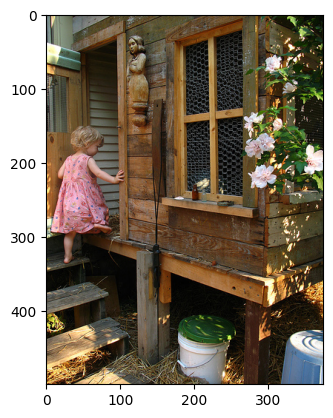

In [23]:
image_name = '1000268201_693b08cb0e.jpg'

generate_caption(image_name)